In [172]:
import numpy as np  
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.table import Table
import os
from astropy.wcs import WCS
from photutils.aperture import CircularAperture, CircularAnnulus
from photutils.aperture import aperture_photometry
from photutils.aperture import ApertureStats
import sep
from reproject import reproject_interp
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.stats import sigma_clip

In [173]:
import warnings
from astropy.wcs import FITSFixedWarning
warnings.simplefilter('ignore', category=FITSFixedWarning)

### Factor F

In [174]:
GAIAspectrum = fits.open('GAIA3_509862066010920960.fits')

def Factor(filtro):

    file_name = f"{filtro}_trasmission.txt"

    r_trasm = Table.read(file_name, format='ascii.basic')
    r_wave=r_trasm["Wavelength(A)"]
    r_value=r_trasm["Transmission(QE*Filter)"]

    r_trasm_new=np.interp(GAIAspectrum[1].data, r_wave, r_value)

    x=GAIAspectrum[1].data
    y_filter=r_trasm_new
    y_spectrum=np.array(GAIAspectrum[0].data)

    Num = np.trapz(y_spectrum * y_filter, x)
    Den= np.trapz(y_filter, x)
    return Num/Den           # Factor for the flux

### Bias 
Independent on anything 


In [175]:
def bias():
    Grid=[]
    path=os.getcwd()+'/bias'
    for file in os.listdir(path):
        fitsfile=fits.open(path+'/'+file)
        dati = fitsfile[0].data
        Grid.append(dati)
    return np.mean(Grid, axis=0)

# it is the same for all the images 
#masterbias=bias()

### Flat

In [176]:
def flat(filtro):   
    pathf=os.getcwd()+f"/{filtro}FLAT"
    
    Grid=[]
    for file in os.listdir(pathf):
        fitsfile=fits.open(pathf+'/'+file)
        dati = fitsfile[0].data
        Grid.append(dati)
    master=np.median(Grid, axis=0)-bias()
    
    return master/np.median(master)

#masterflat=flat('R')
#print(masterflat)

### Dark current

In [177]:
def dark_current(exptime):

    pathd=os.getcwd()+'/DARK'+f'{exptime}'
    Grid=[]
    for file in os.listdir(pathd):
        fitsfile=fits.open(pathd+'/'+file)
        dati = fitsfile[0].data
        Grid.append(dati)

    master=np.median(Grid, axis=0)-bias()
    return master

#mastercurrent=dark_current('300')

In [178]:
def background(data2, pixpos):

    pixpos_x=int(pixpos[0])
    pixpos_y=int(pixpos[1])

    data_cut = data2[pixpos_y-50:pixpos_y+50,pixpos_x-50:pixpos_x+50]
    position = [50, 50]     #in the center 

    ap = CircularAperture(position, r=15)
    photo_inside = aperture_photometry(data_cut,ap)
    final_flux = photo_inside[0][3:]

    annulus_ap=CircularAnnulus(position, r_in=20, r_out=30)
    aperstats= ApertureStats(data_cut, annulus_ap)
    bkg_mean=aperstats.mean

    aperture_area=ap.area
    total_bkg=bkg_mean*aperture_area
    
    return final_flux - total_bkg


In [179]:
c = SkyCoord('01:33:12 +60:42:00', unit=(u.hourangle, u.deg))

ref_wcs =  WCS(naxis=2)

ref_wcs.wcs.crval =[c.ra.degree, c.dec.degree]
ref_wcs.wcs.crpix =[4000/2.0, 4000/2.0]  
ref_wcs.wcs.ctype =["RA---TAN", "DEC--TAN"] 
ref_wcs.wcs.cunit=["deg", "deg"]

#trasformation of 0.55 arcsec/pixel
dim_degrees= (0.55/3600.0)

ref_wcs.wcs.cd= np.array([[-dim_degrees, 0.0], [0.0, dim_degrees]])

In [180]:
def DataProcess(filtro, exptime):

    Path = os.path.join(os.getcwd(), 'DATA', filtro)
    masterbias=bias()
    mastercurrent=dark_current(exptime)
    masterflat=flat(filtro)

    all_images=[]
    Calibrations=[]

    for file in os.listdir(Path):       #for all the file in the filter of a given day

        if not file.lower().endswith('.fits'):
            continue

        Fitsfile=fits.open(Path+'/'+file)

        #read the data 
        Data = Fitsfile[0].data

        #coordinates of the image
        wcs = WCS(Fitsfile[0].header)
        pixpos = wcs.wcs_world2pix(23.38804096055661,60.63702187961969, 1)         #coordinates of the star for calibration

        data1 = (Data-masterbias-mastercurrent)/masterflat
        
        data2=data1*0.25/exptime                                    # to have the flux in e-/s     
        
        Calibration_costant=Factor(filtro)/background(data2, pixpos) #calibartion costant and 10**16 preventing numerical error 
        Calibrations.append(Calibration_costant)

        data3=data2*Calibration_costant*10**16                 #calibartion costant and 10**16 preventing numerical error 
        data=data3-np.median(data3)
        std=np.std(data3)
        objects, map = sep.extract(data, 1.5, err=std, segmentation_map=True)              #return an image 


        bkg = sep.Background(data, mask=map, bw=64, bh=64, fw=12, fh=12)
        Final=data3-bkg

        #reproject the image 
        new_repr= reproject_interp((Final, wcs), ref_wcs, shape_out=(4000,4000))
        all_images.append(new_repr[0])
        #print(new_repr[0])

        #plt.imshow(new_repr[0], vmin=mean_f-2*std_f,vmax=mean_f+2*std_f,cmap='gray', origin='lower')
        #plt.show()
        #print("ok")

    return np.median(all_images, axis=0), np.median(Calibrations, axis=0)       #choose the correct axis 

In [181]:
Result_r, Cal_r = DataProcess('R',300)

In [182]:
Result_mean = np.nanmedian(Result_r)  # ignora i NaN
Result_std  = np.nanstd(Result_r)   # ignora i NaN

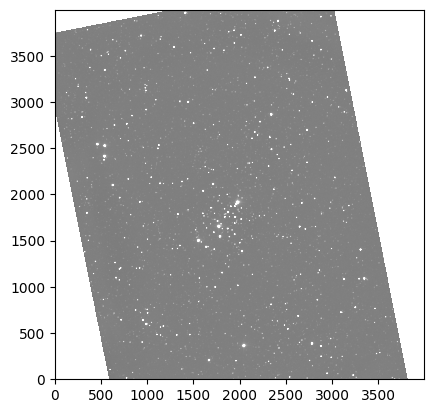

In [183]:
plt.imshow(Result_r, vmin=Result_mean-2*Result_std, vmax=Result_mean+2*Result_std, cmap='gray', origin='lower')

Errors with Sigma_Clipping

In [184]:
def flux_and_errors(Result, pixpos_x, pixpos_y, Cal, exptime, maps_i, clipped):

    pixpos_x=int(pixpos_x)
    pixpos_y=int(pixpos_y)

    Result=Result*maps_i
    data_cut = Result[pixpos_y-50:pixpos_y+50,pixpos_x-50:pixpos_x+50]
    position = [50, 50]     #in the center 

    ap = CircularAperture(position, r=15)
    photo_inside = aperture_photometry(data_cut,ap)
    S = photo_inside[0][3]          #flux inside the aperture
    n_pixels=np.pi*15**2            #area in pixel
    #n_pixels=ap.area

    sigma_b=clipped*np.sqrt(n_pixels)
    sigma_f=np.sqrt(Cal*10**16/exptime*S)         #10**16!!!
    E=np.sqrt(sigma_f**2 + sigma_b**2)

    return S, E

In [210]:
histo_r=Result_r.flatten()
backs_r=sigma_clip(histo_r, sigma=3, maxiters=5)
sigma_back_r=np.std(backs_r)

std_r=np.nanstd(Result_r)
objects_r, map_r = sep.extract(Result_r-np.nanmedian(Result_r), 1.5, err=std_r, segmentation_map=True)
#object gives already the positions
x_star=(objects_r["xmax"]+objects_r["xmin"])/2
y_star=(objects_r["ymax"]+objects_r["ymin"])/2


In [186]:
Flux_star_r = []
Error_r = [] 
for i in range(0,len(x_star)):
    maps_i=map_r/(i+1)
    maps_i[maps_i!=1]=0
    flux, error=flux_and_errors(Result_r, x_star[i], y_star[i], Cal_r, 300, maps_i, sigma_back_r)
    Flux_star_r.append(flux)
    Error_r.append(error)

### the first are nan beacuse they are close to the edges of the images

the we have to convert in magnitude, from flux per armstrong to flux per frequency

In [187]:
lr=6500
c=3*10**(18)
Flux_star_r=np.array(Flux_star_r)*10**(-16)*lr**2/c
Error_r=np.array(Error_r)*10**(-16)*lr**2/c

magnitude_r=-2.5*np.log10(Flux_star_r)-48.6
err_magn_r=-2.5*Error_r/Flux_star_r/np.log(10)

### An other filter

In [188]:
#run other filter 
Result_g, Cal_g = DataProcess('G',300)

In [190]:
histo_g=Result_g.flatten()
backs_g=sigma_clip(histo_g, sigma=3, maxiters=5)
sigma_back_g=np.std(backs_g)

In [191]:
Flux_star_g = []
Error_g = [] 
for i in range(0,len(x_star)):
    maps_i=map_r/(i+1)                  #we use onlt map of r
    maps_i[maps_i!=1]=0
    flux, error=flux_and_errors(Result_g, x_star[i], y_star[i], Cal_g, 300, maps_i, sigma_back_g)
    Flux_star_g.append(flux)
    Error_g.append(error)

In [192]:
## convertion from Flux in wavelegth to frequency
lg=4500
c=3*10**(18)
Flux_star_g=np.array(Flux_star_g)*10**(-16)*lg**2/c
Error_g=np.array(Error_g)*10**(-16)*lg**2/c

magnitude_g=-2.5*np.log10(Flux_star_g)-48.6
err_magn_g=2.5*Error_g/Flux_star_g/np.log(10)

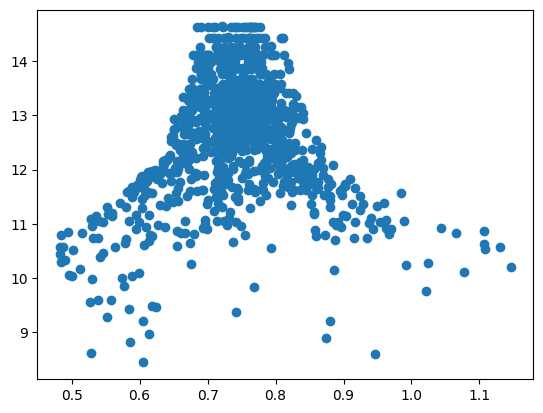

In [193]:
plt.scatter(magnitude_g-magnitude_r, magnitude_r)

The aim of this section is to compute the flux and the related error of each star. The following passages have been performed:
1. Identification of the stars in the image. A first we used sep.extract: by means of sep.extract it is possible to obtain a list of the detected objects in the image. In particular, sep.extract returns a list of features for each object (the useful ones are xmin, xmax, ymin and ymax: they are the minimum and maximum coordinates of the pixels in which the object is present) and a mask (an array with same shape as the image. Pixels not belonging to any object have value 0. All pixels belonging to the i-th object (objects[i]) have value i+1). 

BUT we found out that sep.extract is not suitable because it identifies also stars that are not part of M103 (stars that are just on the line of sight). Thus, it's better to rely on a catalogue of stars used in literature (saved in the file 'M103_membership_selected.fits')


2. The sigma of the background is computed. The process is the same as the previous one: after sigma-clipping the image, the error of the background for a single pixel is obtained. Then, multiplying by the square root of the number of pixels in the aperture, it is possible to find the error of the total background sigma_b.
3. For each object in the catalogue it has been performed aperture photometry in order to obtain the flux of the star. In addition the error of the flux sigma_f (see the notes) is computed and a squared sum is performed between sigma_f and sigma_b to find the error related to the star.
4. The flux in lambda units is transformed into flux in frequency units. The magnitude has been obtained. Thanks to error propagation, the error related to the magnitude has been computed.
5. A scatter plot is used to analyze the magnitude vs the color.

### Correct result (from literature) using the Cathalog

In [194]:
def flux_and_errors2(Result, pixpos, Cal, exptime, clipped):


    data_cut = Result[int(pixpos[1]-50):int(pixpos[1]+50),int(pixpos[0]-50):int(pixpos[0]+50)]
    position = [50, 50]     #in the center 

    ap = CircularAperture(position, r=15)
    photo_inside = aperture_photometry(data_cut,ap)
    aperture_sum=photo_inside[0][3]

    annulus_aperture = CircularAnnulus(position, r_in=20, r_out=30)
    aperstats = ApertureStats(data_cut, annulus_aperture)
     # inside apertstats I save all the statistics of the area defined by annulus_aperture. The one I will use is the mean
    bkg_mean = aperstats.mean   # mean background for each pixel

    # I compute the flux (I need to subtract the background!)
    aperture_area = ap.area_overlap(data_cut) # aperture area with r=15
    total_bkg = bkg_mean * np.array(aperture_area)
    clipped_bkg=sigma_clip(total_bkg)
    phot_bkgsub =  np.array(aperture_sum) - clipped_bkg                 # I subtract the background
   
    n_pixels=ap.area

    sigma_b=clipped*np.sqrt(n_pixels)
    sigma_f=np.sqrt((Cal*10**16/exptime*phot_bkgsub))         #10**16!!!
    E=np.sqrt(sigma_f**2 + sigma_b**2)
     
    return phot_bkgsub, E

In [195]:
# I read the list of stars in M103 and I save their RA and Dec
catalogue = Table.read('M103_membership_selected.fits')
pixpos=ref_wcs.wcs_world2pix(catalogue['RAdeg'], catalogue['DEdeg'],1)

In [196]:
histo_r=Result_r.flatten()
backs_r=sigma_clip(histo_r, sigma=3, maxiters=5)
clipped_r=np.std(backs_r)

In [197]:
histo_g=Result_g.flatten()
backs_g=sigma_clip(histo_g, sigma=3, maxiters=5)
clipped_g=np.std(backs_g)

In [198]:
Flux_star_g = []
Error_g = [] 
for i in range(0,len(catalogue)):
    
    flux, error=flux_and_errors2(Result_g, [pixpos[0][i], pixpos[1][i]], Cal_g, 300, sigma_back_g)
    Flux_star_g.append(flux)
    Error_g.append(error)

#same fluxes are negative!!!

/var/folders/1g/z7752nkn6ll0x7fywxm98ld80000gn/T/ipykernel_37247/3559308188.py:25: RuntimeWarning: invalid value encountered in sqrt
  sigma_f=np.sqrt((Cal*10**16/exptime*phot_bkgsub))         #10**16!!!
/var/folders/1g/z7752nkn6ll0x7fywxm98ld80000gn/T/ipykernel_37247/3559308188.py:25: RuntimeWarning: invalid value encountered in sqrt
  sigma_f=np.sqrt((Cal*10**16/exptime*phot_bkgsub))         #10**16!!!
/var/folders/1g/z7752nkn6ll0x7fywxm98ld80000gn/T/ipykernel_37247/3559308188.py:25: RuntimeWarning: invalid value encountered in sqrt
  sigma_f=np.sqrt((Cal*10**16/exptime*phot_bkgsub))         #10**16!!!
/var/folders/1g/z7752nkn6ll0x7fywxm98ld80000gn/T/ipykernel_37247/3559308188.py:25: RuntimeWarning: invalid value encountered in sqrt
  sigma_f=np.sqrt((Cal*10**16/exptime*phot_bkgsub))         #10**16!!!
/var/folders/1g/z7752nkn6ll0x7fywxm98ld80000gn/T/ipykernel_37247/3559308188.py:25: RuntimeWarning: invalid value encountered in sqrt
  sigma_f=np.sqrt((Cal*10**16/exptime*phot_bkgsub))

In [199]:
Flux_star_r = []
Error_r = [] 
for i in range(0,len(catalogue)):
    flux, error=flux_and_errors2(Result_r, [pixpos[0][i], pixpos[1][i]], Cal_r, 300, sigma_back_r)
    Flux_star_r.append(flux)
    Error_r.append(error)

/var/folders/1g/z7752nkn6ll0x7fywxm98ld80000gn/T/ipykernel_37247/3559308188.py:25: RuntimeWarning: invalid value encountered in sqrt
  sigma_f=np.sqrt((Cal*10**16/exptime*phot_bkgsub))         #10**16!!!
/var/folders/1g/z7752nkn6ll0x7fywxm98ld80000gn/T/ipykernel_37247/3559308188.py:25: RuntimeWarning: invalid value encountered in sqrt
  sigma_f=np.sqrt((Cal*10**16/exptime*phot_bkgsub))         #10**16!!!
/var/folders/1g/z7752nkn6ll0x7fywxm98ld80000gn/T/ipykernel_37247/3559308188.py:25: RuntimeWarning: invalid value encountered in sqrt
  sigma_f=np.sqrt((Cal*10**16/exptime*phot_bkgsub))         #10**16!!!
/var/folders/1g/z7752nkn6ll0x7fywxm98ld80000gn/T/ipykernel_37247/3559308188.py:25: RuntimeWarning: invalid value encountered in sqrt
  sigma_f=np.sqrt((Cal*10**16/exptime*phot_bkgsub))         #10**16!!!
/var/folders/1g/z7752nkn6ll0x7fywxm98ld80000gn/T/ipykernel_37247/3559308188.py:25: RuntimeWarning: invalid value encountered in sqrt
  sigma_f=np.sqrt((Cal*10**16/exptime*phot_bkgsub))

In [200]:
# convertion from flux in wavelegth to frequency
lg=4500
c=3*10**(18)
Flux_star_g2=np.array(Flux_star_g)*10**(-16)*lg**2/c
Error_g2=np.array(Error_g)*10**(-16)*lg**2/c

magnitude_g2=-2.5*np.log10(Flux_star_g2)-48.6
err_magn_g2=2.5*np.array(Error_g2.flatten()/Flux_star_g2/np.log(10))

lr=6500
Flux_star_r2=np.array(Flux_star_r)*10**(-16)*lr**2/c
Error_r2=np.array(Error_r)*10**(-16)*lr**2/c

magnitude_r2=np.array(-2.5*np.log10(Flux_star_r2)-48.6)
err_magn_r2=2.5*Error_r2.flatten()/Flux_star_r2/np.log(10)


/var/folders/1g/z7752nkn6ll0x7fywxm98ld80000gn/T/ipykernel_37247/968030715.py:7: RuntimeWarning: invalid value encountered in log10
  magnitude_g2=-2.5*np.log10(Flux_star_g2)-48.6
/var/folders/1g/z7752nkn6ll0x7fywxm98ld80000gn/T/ipykernel_37247/968030715.py:14: RuntimeWarning: invalid value encountered in log10
  magnitude_r2=np.array(-2.5*np.log10(Flux_star_r2)-48.6)


(24.0, 8.0)

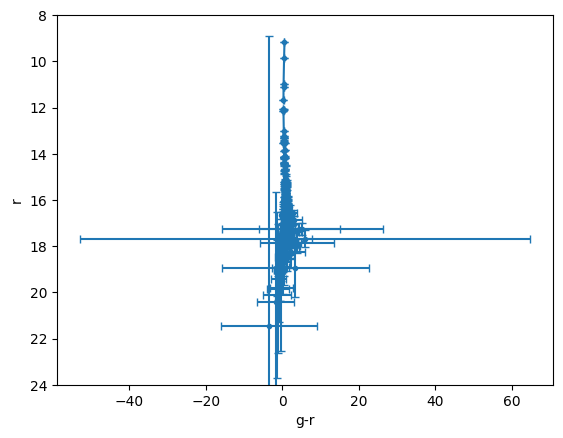

In [201]:
plt.scatter(magnitude_g2 - magnitude_r2, magnitude_r2, marker='.')
plt.errorbar(magnitude_g2 - magnitude_r2, magnitude_r2, xerr=  np.sqrt(err_magn_g2**2 + err_magn_r2**2), yerr=err_magn_r2, capsize=3)
plt.xlabel('g-r')
plt.ylabel('r')
plt.ylim(24, 8)


(24.0, 8.0)

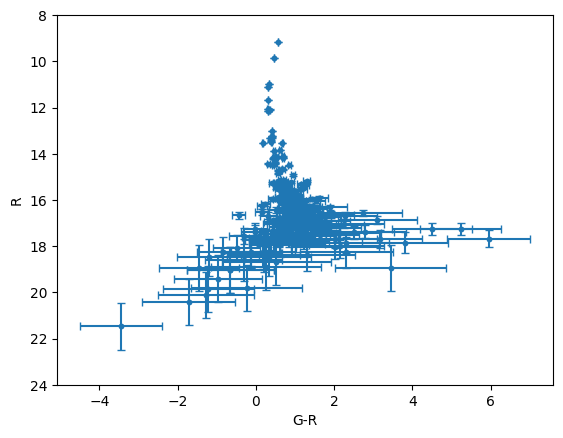

In [202]:
## BIG errors!!

err_mag_r_limit = err_magn_r2
err_mag_g_limit = err_magn_g2


err_mag_r_limit[err_mag_r_limit > 1] = 1
err_mag_g_limit[err_mag_g_limit > 1] = 1


plt.scatter(magnitude_g2 - magnitude_r2, magnitude_r2, marker='.')
plt.errorbar(magnitude_g2 - magnitude_r2, magnitude_r2, xerr=  np.sqrt(err_magn_g2**2 + err_magn_r2**2), yerr=err_magn_r2, capsize=3, marker='.', linestyle='')
plt.xlabel('G-R')
plt.ylabel('R')
plt.ylim(24, 8)

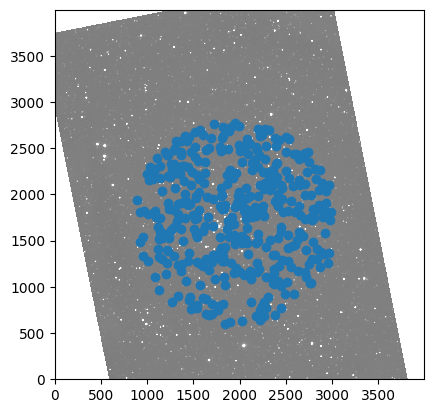

In [206]:
catalogue = Table.read('M103_membership_selected.fits')
plt.imshow(Result_r, vmin=Result_mean-2*Result_std, vmax=Result_mean+2*Result_std, cmap='gray', origin='lower')
plt.scatter(pixpos[0], pixpos[1])


## Isochrones 

In [215]:
mask=magnitude_r2<17
m_r=magnitude_r2[mask]
err_r=err_magn_r2[mask]
m_g=magnitude_g2[mask]
err_g=err_magn_g2[mask]

In [226]:
isochrone = Table.read('isochrone_grid_parsec.dat', format='ascii')


In [247]:
mask_metal=isochrone['MH']==0     #solar metallicity 
mask_age=isochrone['logAge']==6 

rmag=isochrone['rmag']
gmag=isochrone['gmag']


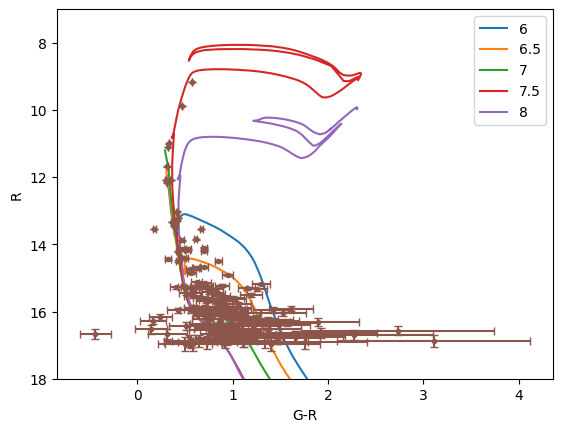

In [268]:
ages=[6,6.5,7,7.5,8]
for a in ages:
    mask_age=isochrone['logAge']==a 
    r = rmag[(mask_metal&mask_age)]
    g = gmag[(mask_metal&mask_age)]
    color = g-r
    plt.plot(color+0.8, r+14, label=a)
   

#first age 
plt.errorbar(m_g - m_r, m_r, xerr=  np.sqrt(err_g**2 + err_r**2), yerr=err_r, capsize=3, marker='.', linestyle='')
plt.xlabel('G-R')
plt.ylabel('R')
plt.ylim(18, 7)
plt.legend()


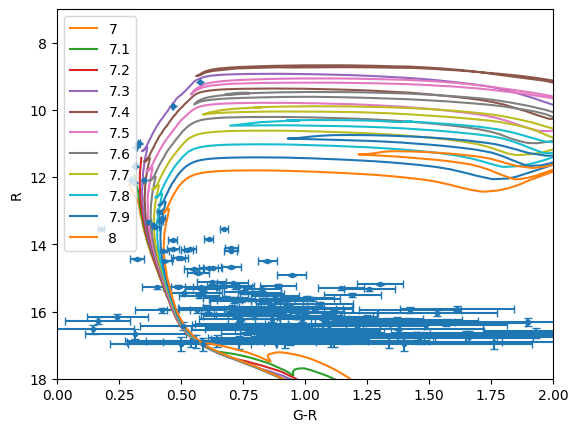

In [276]:
plt.errorbar(m_g - m_r, m_r, xerr=  np.sqrt(err_g**2 + err_r**2), yerr=err_r, capsize=3, marker='.', linestyle='')
plt.xlabel('G-R')
plt.ylabel('R')
plt.ylim(18, 7)
plt.xlim(0, 2)


ages=[7,7.1,7.2,7.3,7.4,7.5,7.6,7.7,7.8,7.9,8]
for a in ages:
    mask_age=isochrone['logAge']==a 
    r = rmag[(mask_metal&mask_age)]
    g = gmag[(mask_metal&mask_age)]
    color = g-r
    plt.plot(color+0.8, r+15, label=a)

plt.legend()